# Plan Analytics for Medications vs Gender
This script is for planning the analytics for the focus question: What, if any, relationship exists between __medications given__ and __genders of patient and provider__?

_Author: Jared Gauntt_

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

### Assumptions
This script reads in the joined Patients and Medications dataset from the data/02_intermediate folder. Each row represents a single instance of a medication given to a patient. If a single patient is given one medication multiple times, that would be reflected as multiple rows in this dataset.

FRDPersonnelID 9E5D40DC-5DC6-E411-80C7-001DD8B71D38 had many duplicate records in the raw Medications dataset that could be removed per our FCFRD partners. These duplicates were removed prior to the joining process.

Categorical variables were converted to numerical values prior to the joining process. These were added as additional columns so that the original categorical values were also retained in the dataset.

Rows in the raw Patients dataset with null Provider Gender or Provider Start Date were dropped prior to the joining process. Rows with null Patient Gender were retained for the other focus question using this dataset. Null Patient Gender rows will need to be removed prior to this analysis.

### Import and Inspect Data

In [2]:
#Import CSV
localFolder='../data/02_intermediate/' #If run from Git Hub project folder structure, script must be in "notebooks" folder
fileName='MedicationsPatients-20210225-ems-raw-v04.csv'
columnsToUse=['PatientId','PatientGender','PatientGenderCode',
            'FRDPersonnelID','FRDPersonnelGender','ProviderGenderCode',
            'Medication_Given_RXCUI_Code','Medication_Given_Description']
dfAll=pd.read_csv(localFolder+fileName, usecols=columnsToUse)[columnsToUse]

In [3]:
#Calculate number of rows
len(dfAll)

62881

In [4]:
#Calculate number of unique values per column
dfAll.nunique(dropna=False)

PatientId                       38389
PatientGender                       4
PatientGenderCode                   4
FRDPersonnelID                    844
FRDPersonnelGender                  2
ProviderGenderCode                  2
Medication_Given_RXCUI_Code        33
Medication_Given_Description       33
dtype: int64

In [5]:
#Calculate number of nulls per column
dfAll.isnull().sum()

PatientId                        0
PatientGender                   32
PatientGenderCode                0
FRDPersonnelID                   0
FRDPersonnelGender               0
ProviderGenderCode               0
Medication_Given_RXCUI_Code      6
Medication_Given_Description     6
dtype: int64

Since the null values for PatientGender and Medication represent a negligible portion of the records, they will be removed prior to analysis. We can bring the 6 null medications to our FCFRD partners' attention.

In [6]:
#Confirm Patient Gender values
dfAll['PatientGender'].value_counts(dropna=False)

Male                             32536
Female                           30289
NaN                                 32
Unknown (Unable to Determine)       24
Name: PatientGender, dtype: int64

Since the Unknown category represents a neglibile portion of the records, they will be removed prior to analysis. This will be noted in the report.

In [7]:
#Reduce to unique Patients and count gender
dfAll[['PatientId','PatientGender']].drop_duplicates()['PatientGender'].value_counts()

Male                             19312
Female                           19039
Unknown (Unable to Determine)       16
Name: PatientGender, dtype: int64

Male and female patients are balanced.

In [8]:
#Confirm Provider Gender values
dfAll['FRDPersonnelGender'].value_counts(dropna=False)

Male      52356
Female    10525
Name: FRDPersonnelGender, dtype: int64

In [9]:
#Reduce to unique Providers and count gender
dfAll[['FRDPersonnelID','FRDPersonnelGender']].drop_duplicates()['FRDPersonnelGender'].value_counts()

Male      695
Female    149
Name: FRDPersonnelGender, dtype: int64

When performing analysis on Provider Gender, we will have to be careful to account for the large imbalance between number of male and female providers.

### Reduce Data

In [10]:
#Remove all rows with any nulls
dfReduced=dfAll.loc[dfAll.isnull().sum(axis=1)==0,:]

#Remove unknown category for PatientGender
dfReduced=dfReduced.loc[dfReduced['PatientGender']!='Unknown (Unable to Determine)',:]

#Calculate percentage of dataset remaining
len(dfReduced)/len(dfAll)*100

99.90140105914345

## Prepare Processed Datasets

### Prepare dataframe where each row is unique Patient/Provider interaction (one or more medications given)

In [11]:
#Determine the unique interactions (Provider to Patient) independent of number/types of medications given during that interaction
dfInteractions=dfReduced[['PatientId','PatientGender','FRDPersonnelID','FRDPersonnelGender']].drop_duplicates()

#Add a column that specifies the Provider-Patient gender relationship
dfInteractions['GenderRelationship']=dfInteractions['FRDPersonnelGender'].str.cat(dfInteractions['PatientGender'],sep=' treat ')
dfInteractions['GenderRelationshipCode']=dfInteractions['GenderRelationship'].factorize()[0]

#Add a column that characterizes whether the Provider and Patient Genders match each other
dfInteractions['SameGender']=(dfInteractions['PatientGender']==dfInteractions['FRDPersonnelGender'])

#Calculate the number of rows per each Patient/Provider pair
dfNumRowsPerPatientProviderPair=dfReduced.groupby(['PatientId','FRDPersonnelID'],as_index=False).size()
dfNumRowsPerPatientProviderPair.rename(columns={'size':'NumMedicationsGiven'},inplace=True)
dfInteractions=dfInteractions.merge(dfNumRowsPerPatientProviderPair,how='inner',on=['PatientId','FRDPersonnelID'])

#Calculate the number of rows per each Patient/Provider/Medication triplet
dfNumRowsPerPatentProviderMedicationTriplet=dfReduced[['PatientId','FRDPersonnelID','Medication_Given_RXCUI_Code']].drop_duplicates().groupby(
    ['PatientId','FRDPersonnelID'],as_index=False).size()
dfNumRowsPerPatentProviderMedicationTriplet.rename(columns={'size':'NumUniqueMedicationsGiven'},inplace=True)
dfInteractions=dfInteractions.merge(dfNumRowsPerPatentProviderMedicationTriplet,how='inner',on=['PatientId','FRDPersonnelID'])

#Add a column that characterizes whether at least one medication was given more than once on a call
dfInteractions['MultiplesOfMedicationGiven']=(dfInteractions['NumMedicationsGiven']!=dfInteractions['NumUniqueMedicationsGiven'])

### Prepare dataframe where each row is a unique Medication

In [12]:
#Determine number of records
dfMedications=pd.DataFrame(pd.Series(dfReduced['Medication_Given_Description'].value_counts(),name='Number of Doses Given'))

#Number of patients per unique medication
dfMedications_UniquePatients=dfReduced[['PatientId','PatientGender','Medication_Given_Description']].drop_duplicates()[
    ['Medication_Given_Description','PatientGender']]
dsNumMalePatients=pd.Series(dfMedications_UniquePatients.loc[dfMedications_UniquePatients['PatientGender']=='Male',
    'Medication_Given_Description'].value_counts(),name='Number of Male Patients')
dsNumFemalePatients=pd.Series(dfMedications_UniquePatients.loc[dfMedications_UniquePatients['PatientGender']=='Female',
    'Medication_Given_Description'].value_counts(),name='Number of Female Patients')
dfMedications=pd.merge(dfMedications,dsNumMalePatients,how='left',left_index=True,right_index=True)
dfMedications=pd.merge(dfMedications,dsNumFemalePatients,how='left',left_index=True,right_index=True)

#Number of providers per unique medication
dfMedications_UniqueProviders=dfReduced[['FRDPersonnelID','FRDPersonnelGender','Medication_Given_Description']].drop_duplicates()[
    ['Medication_Given_Description','FRDPersonnelGender']]
dsNumMaleProviders=pd.Series(dfMedications_UniqueProviders.loc[dfMedications_UniqueProviders['FRDPersonnelGender']=='Male',
    'Medication_Given_Description'].value_counts(),name='Number of Male Providers')
dsNumFemaleProviders=pd.Series(dfMedications_UniqueProviders.loc[dfMedications_UniqueProviders['FRDPersonnelGender']=='Female',
    'Medication_Given_Description'].value_counts(),name='Number of Female Providers')
dfMedications=pd.merge(dfMedications,dsNumMaleProviders,how='left',left_index=True,right_index=True)
dfMedications=pd.merge(dfMedications,dsNumFemaleProviders,how='left',left_index=True,right_index=True)

dfMedications.fillna(0,inplace=True)

#Gender percentage of Patients receiving medication
dsTotalPatients=dfMedications['Number of Male Patients']+dfMedications['Number of Female Patients']
dfMedications['Dist Male Patients']=round(dfMedications['Number of Male Patients']/dsTotalPatients*100,1)
dfMedications['Dist Female Patients']=round(dfMedications['Number of Female Patients']/dsTotalPatients*100,1)

#Gender percentage of Providers giving medication
dsTotalProviders=dfMedications['Number of Male Providers']+dfMedications['Number of Female Providers']
dfMedications['Dist Male Providers']=round(dfMedications['Number of Male Providers']/dsTotalProviders*100,1)
dfMedications['Dist Female Providers']=round(dfMedications['Number of Female Providers']/dsTotalProviders*100,1)

## Analysis

Are Providers likely to give medications to both Patient genders or are they biased towards a particular gender?

Are the number of medications given related to the relationship between Provider and Patient Gender?

Are the number of unique medications given related to the relationship between Provider and Patient Gender?

Are some medications given more to a certain Patient Gender?

Are some medications given more by a certain Provider Gender?

### Are Providers likely to give medications to both Patient genders or are they biased towards a particular gender?

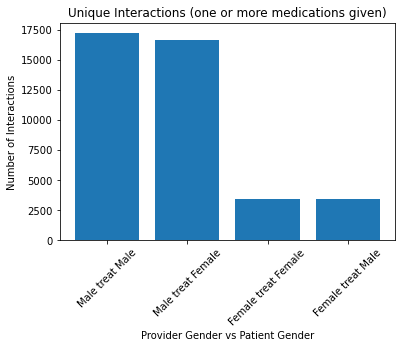

In [13]:
#For each unique interaction (Provider to Patient), plot the gender relationship
fig,ax=plt.subplots()
ax.bar(x=dfInteractions['GenderRelationship'].value_counts().index,height=dfInteractions['GenderRelationship'].value_counts())
ax.set_xlabel('Provider Gender vs Patient Gender')
ax.set_ylabel('Number of Interactions')
ax.set_title('Unique Interactions (one or more medications given)')
plt.xticks(rotation=45)
plt.show()

This bar chart indicates that Providers give medications to both Patient genders in a balanced fashion.

### Are the number of medications given related to the relationship between Provider and Patient Gender?
The number of medications given includes unique medications that were given more than once.

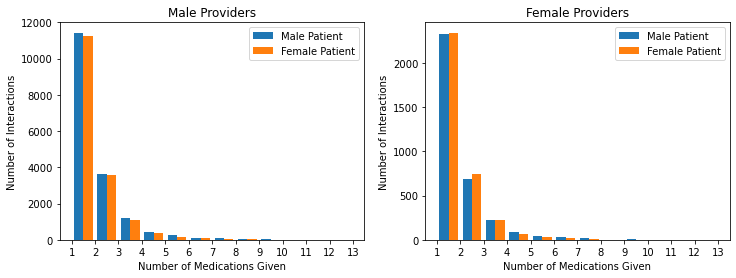

In [14]:
#For each unique interaction (Provider to Patient), plot the gender relationship
setBins=list(range(1,dfInteractions['NumMedicationsGiven'].max()+1))
fig=plt.figure(figsize=(12,4))

#Male Providers
ax1=plt.subplot(121)
ax1.hist([dfInteractions.loc[dfInteractions['GenderRelationship']=='Male treat Male','NumMedicationsGiven'],
        dfInteractions.loc[dfInteractions['GenderRelationship']=='Male treat Female','NumMedicationsGiven']],
        label=['Male Patient','Female Patient'],bins=setBins)
ax1.set_xticks(setBins)
ax1.set_xlabel('Number of Medications Given')
ax1.set_ylabel('Number of Interactions')
ax1.set_title('Male Providers')
ax1.legend(loc='upper right')

#Female Providers
ax2=plt.subplot(122)
ax2.hist([dfInteractions.loc[dfInteractions['GenderRelationship']=='Female treat Male','NumMedicationsGiven'],
        dfInteractions.loc[dfInteractions['GenderRelationship']=='Female treat Female','NumMedicationsGiven']],
        label=['Male Patient','Female Patient'],bins=setBins)
ax2.set_xticks(setBins)
ax2.set_xlabel('Number of Medications Given')
ax2.set_ylabel('Number of Interactions')
ax2.set_title('Female Providers')
ax2.legend(loc='upper right')

#Show
plt.show()

While the Female Providers number of interactions is much lower than that of Male Providers, the behavior by Male and Female Providers appears to be similar. They are scaled differently due to the ratio of Male to Female Providers in FCFRD.

### Are the number of unique medications given related to the relationship between Provider and Patient Gender?
If a unique medication is given more than once on a call, it is only captured once in this metric.

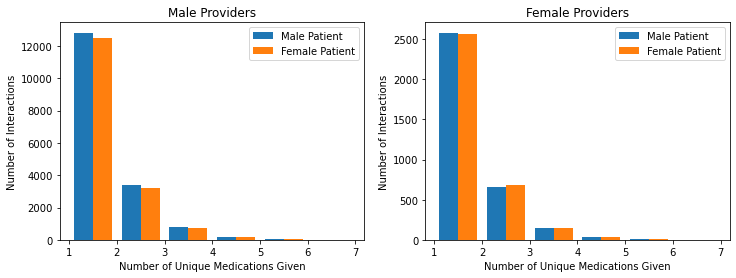

In [15]:
#For each unique interaction (Provider to Patient), plot the gender relationship
setBins=list(range(1,dfInteractions['NumUniqueMedicationsGiven'].max()+1))
fig=plt.figure(figsize=(12,4))

#Male Providers
ax1=plt.subplot(121)
ax1.hist([dfInteractions.loc[dfInteractions['GenderRelationship']=='Male treat Male','NumUniqueMedicationsGiven'],
        dfInteractions.loc[dfInteractions['GenderRelationship']=='Male treat Female','NumUniqueMedicationsGiven']],
        label=['Male Patient','Female Patient'],bins=setBins)
ax1.set_xticks(setBins)
ax1.set_xlabel('Number of Unique Medications Given')
ax1.set_ylabel('Number of Interactions')
ax1.set_title('Male Providers')
ax1.legend(loc='upper right')

#Female Providers
ax2=plt.subplot(122)
ax2.hist([dfInteractions.loc[dfInteractions['GenderRelationship']=='Female treat Male','NumUniqueMedicationsGiven'],
        dfInteractions.loc[dfInteractions['GenderRelationship']=='Female treat Female','NumUniqueMedicationsGiven']],
        label=['Male Patient','Female Patient'],bins=setBins)
ax2.set_xticks(setBins)
ax2.set_xlabel('Number of Unique Medications Given')
ax2.set_ylabel('Number of Interactions')
ax2.set_title('Female Providers')
ax2.legend(loc='upper right')

#Show
plt.show()

The behavior in these histograms matches that of the Number of Medications Given histograms above. 

Is giving a unique medication more than once related to the relationship between Provider and Patient Gender?

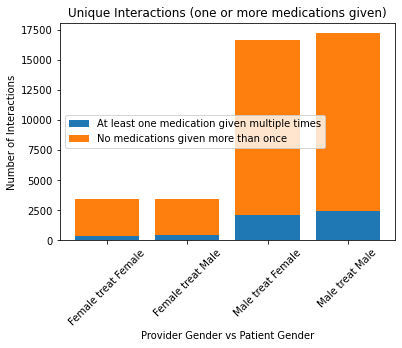

In [16]:
#For each unique interaction (Provider to Patient), plot the gender relationship vs whether or not at least one unique medication
#was given more than once
fig,ax=plt.subplots()
true=dfInteractions.loc[dfInteractions['MultiplesOfMedicationGiven']==True,:]
false=dfInteractions.loc[dfInteractions['MultiplesOfMedicationGiven']==False,:]
ax.bar(x=true['GenderRelationship'].value_counts().sort_index().index,height=true['GenderRelationship'].value_counts().sort_index())
ax.bar(x=false['GenderRelationship'].value_counts().sort_index().index,height=false['GenderRelationship'].value_counts().sort_index(),
      bottom=true['GenderRelationship'].value_counts().sort_index())
plt.xticks(rotation=45)
ax.set_xlabel('Provider Gender vs Patient Gender')
ax.set_ylabel('Number of Interactions')
ax.set_title('Unique Interactions (one or more medications given)')
plt.legend(['At least one medication given multiple times','No medications given more than once'],loc='center left')
plt.show()

Again, behavior doesn't seem to be impacted by gender. Although, I don't know if this metric is even relevant.

### Are some medications given more to a certain gender patient?

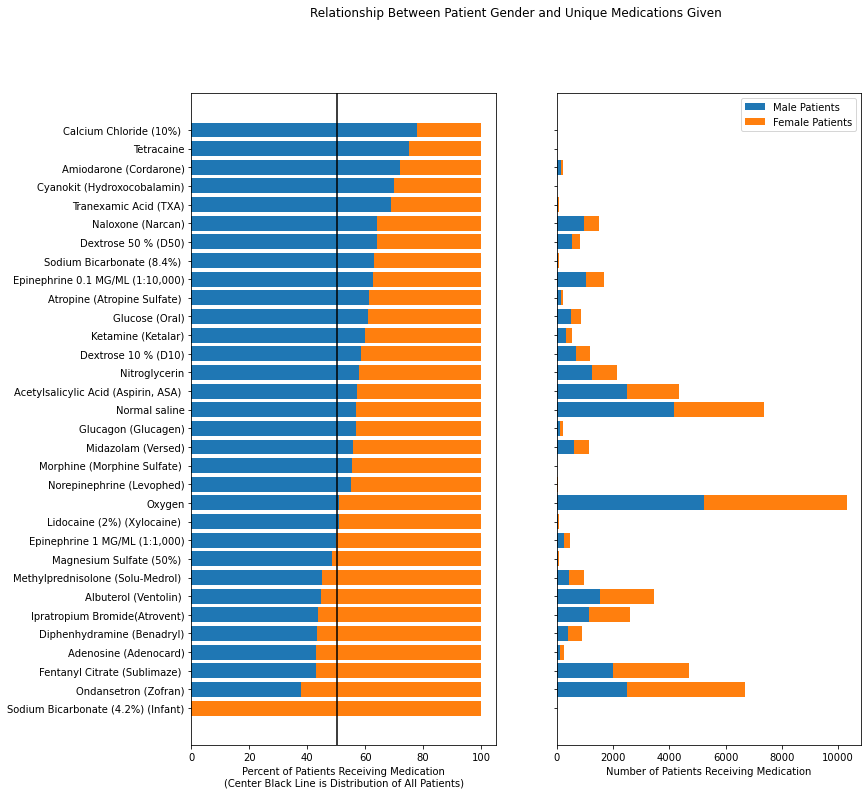

In [17]:
fig=plt.figure(figsize=(12,12))
dfMedications.sort_values(by='Dist Male Patients',inplace=True)

#Bar chart
ax1=plt.subplot(121)
ax1.barh(y=dfMedications.index,width=dfMedications['Dist Male Patients'])
ax1.barh(y=dfMedications.index,width=dfMedications['Dist Female Patients'],left=dfMedications['Dist Male Patients'])
ax1.set_xlabel('Percent of Patients Receiving Medication\n(Center Black Line is Distribution of All Patients)')

#Draw vertical line on boxplot indicating the percentage of male patients vs female patients
patientCount=dfReduced[['PatientId','PatientGender']].drop_duplicates()['PatientGender'].value_counts()
ax1.axvline(x=(patientCount['Male']/(patientCount.sum())*100),color='black')

#Bar chart
ax2=plt.subplot(122)
ax2.barh(y=dfMedications.index,width=dfMedications['Number of Male Patients'])
ax2.barh(y=dfMedications.index,width=dfMedications['Number of Female Patients'],left=dfMedications['Number of Male Patients'])
ax2.set_xlabel('Number of Patients Receiving Medication')
ax2.set_yticklabels([])
ax2.legend(['Male Patients','Female Patients'])

fig.suptitle('Relationship Between Patient Gender and Unique Medications Given')
plt.show()

Not sure if the fact that the percentages are not centered around 50% is an indicator of anything.

### Are some medications given more by a certain gender provider?

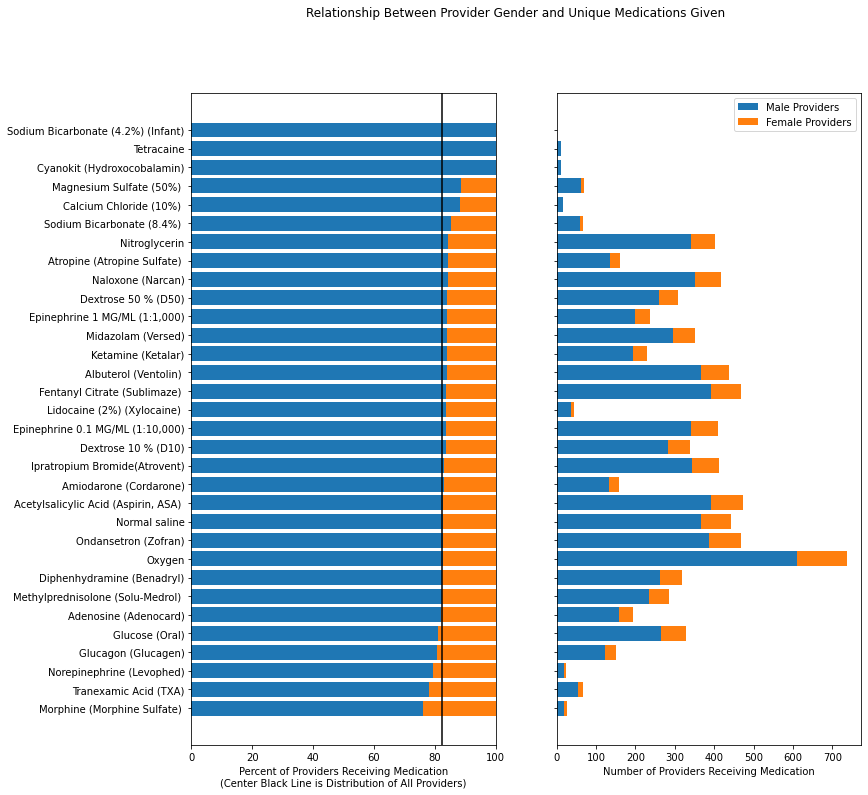

In [18]:
fig=plt.figure(figsize=(12,12))
dfMedications.sort_values(by='Dist Male Providers',inplace=True)

#Bar chart
ax1=plt.subplot(121)
ax1.barh(y=dfMedications.index,width=dfMedications['Dist Male Providers'])
ax1.barh(y=dfMedications.index,width=dfMedications['Dist Female Providers'],left=dfMedications['Dist Male Providers'])
ax1.set_xlabel('Percent of Providers Receiving Medication\n(Center Black Line is Distribution of All Providers)')

#Draw vertical line on boxplot indicating the percentage of male patients vs female patients
providerCount=dfReduced[['FRDPersonnelID','FRDPersonnelGender']].drop_duplicates()['FRDPersonnelGender'].value_counts()
ax1.axvline(x=(providerCount['Male']/(providerCount.sum())*100),color='black')

#Bar chart
ax2=plt.subplot(122)
ax2.barh(y=dfMedications.index,width=dfMedications['Number of Male Providers'])
ax2.barh(y=dfMedications.index,width=dfMedications['Number of Female Providers'],left=dfMedications['Number of Male Providers'])
ax2.set_xlabel('Number of Providers Receiving Medication')
ax2.set_yticklabels([])
ax2.legend(['Male Providers','Female Providers'])

fig.suptitle('Relationship Between Provider Gender and Unique Medications Given')
plt.show()

For most of the medications, the percentage of male providers vs female providers is close to the overall percentage of male providers vs female providers. The tails at either end are associated with medications that have few instances. For example, Sodium Bicarbonate (Infant) was only given once, so it's value is 100%.